# Final Benchmark Data Generation

### Dataset 1 Formula:

Y = w1*x1 + w2*x2 + ... + wN*xN + iw1*I1 + iw2*I2 + ... + iwM*IM + Noise

Where I1, I2, ... are randomly chosen interaction terms xA*xB

In [1]:
import numpy as np
import pandas as pd

In [2]:
n_rows = 5000

# x1, x2, ... , xN
n_features = 50

# x1*x5, x4*x17, x13^2, etc
n_interaction = n_features

## Generate weights for the regular features randomly

In [3]:
# weights for n_features
def make_w(n_features):
    # number of features that will be over the threshold (>0.85 or <-0.85)
    n_sig = round(n_features * 3 / 10)
    # randomly select some (n_sig) weights to make significant (>0.85 or <-0.85)
    big_ws = np.random.choice([ i for i in range(n_features) ], size=n_sig, replace=False)
    ws = np.random.rand(n_features)*.2-.1 # set all weights to between -.1 to .1
    # Update the randomly selected significant weights
    for i in big_ws:
        ws[i] = np.random.rand()*0.15 + (1-0.15) # set weight to be between 0.85 and 1.0
        ws[i] *= 2*int(np.random.rand()<0.5)-1 # randomly set positive or negative
        print(i, ws[i])
    return ws

w_features = make_w(n_features)
w_features

21 0.9953002259630901
2 0.867983352993698
30 -0.9995359952753742
37 -0.8966454175312922
8 0.9307308469826597
17 0.9923577257299446
26 0.8999445690099733
47 -0.95824105146432
0 -0.9511187610609034
14 0.8664042739976784
11 0.8850709936307422
29 0.9023501178680206
48 -0.9204889981519494
5 0.9060623294338506
42 -0.8896961831447805


array([-9.51118761e-01, -9.89442006e-02,  8.67983353e-01, -5.31483405e-02,
       -5.64759030e-02,  9.06062329e-01, -7.35556964e-02,  9.34681255e-02,
        9.30730847e-01, -4.55812720e-02,  7.55211343e-02,  8.85070994e-01,
       -5.97749454e-03,  5.51923352e-02,  8.66404274e-01, -6.43828006e-02,
       -8.90721716e-02,  9.92357726e-01,  8.53247861e-02, -7.00149837e-02,
        4.72147503e-02,  9.95300226e-01, -5.78000600e-02, -6.45693323e-02,
       -6.84333941e-02,  1.94312872e-03,  8.99944569e-01,  5.07821062e-02,
        7.17572767e-02,  9.02350118e-01, -9.99535995e-01, -4.05996593e-03,
        6.25461855e-02,  5.65241442e-02,  8.31320448e-02,  5.30572225e-02,
        6.90748098e-02, -8.96645418e-01,  8.83283925e-04,  9.60468407e-02,
        3.31999647e-02,  1.52137814e-02, -8.89696183e-01,  4.66653508e-02,
        7.09233713e-02, -1.22806839e-02,  8.93027490e-02, -9.58241051e-01,
       -9.20488998e-01, -3.57465563e-03])

## Generate grid of interaction term weights randomly

In [4]:
# interaction terms
def generate_pair():
    # Returns a tuple of two feature numbers representing an interaction term
    return tuple((np.random.rand(2)*n_features // 1).astype(int))

def make_interaction_w(n_features):
    # Generates the grid of weights for the interaction terms
    grid = np.zeros((n_features, n_features))
    all_terms = []
    for i in range(n_interaction):
        # select two random features to multiply together, using while to avoid duplicates
        terms = generate_pair()
        while terms in all_terms: # ensure no repeated interaction pairs
            terms = generate_pair()
        weight = np.random.rand()*0.15 + (1-0.15) # set weight to be between 0.85 and 1.0
        weight *= 2*int(np.random.rand()<0.5)-1 # randomly set positive or negative
        grid[terms[0], terms[1]] = weight
        all_terms.append(terms)
    return grid, all_terms

w_interaction, terms = make_interaction_w(n_features)
w_interaction, terms

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.89671048],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 [(14, 0),
  (5, 38),
  (0, 21),
  (47, 32),
  (11, 40),
  (38, 43),
  (15, 42),
  (10, 24),
  (41, 22),
  (11, 41),
  (38, 32),
  (46, 48),
  (6, 13),
  (34, 43),
  (48, 49),
  (31, 16),
  (31, 13),
  (46, 1),
  (20, 16),
  (46, 8),
  (37, 26),
  (22, 43),
  (29, 9),
  (46, 37),
  (23, 6),
  (38, 26),
  (44, 18),
  (38, 44),
  (28, 9),
  (11, 23),
  (9, 9),
  (29, 7),
  (33, 40),
  (8, 8),
  (34, 8),
  (4

## Generate Y values from X and weights

In [5]:
def calculate_y(X_real):
    # Determine y values with linear combination of X*weights, interaction terms, and Noise
    # 5% with weird weights
    X_w = np.copy(X_real)
    for i in range(len(X_w)):
        weird = np.random.rand()
        if weird > 0.98:
            print(weird)
            X_w[i] = X_w[i] * np.random.rand(len(X_w[i]))
    
    # dot product X values with weights
    y1 = np.dot(X_w, w_features)
    # calculate interaction terms
    X_interaction = pd.DataFrame()
    wi = []
    for t in terms:
        X_interaction[t] = X_w[:,t[0]]*X_w[:,t[1]]
        wi.append(w_interaction[t[0], t[1]])
    # dot product interaction terms with interaction weights
    y2 = np.dot(np.array(X_interaction), wi)
    y_reg = y1 + y2 + np.random.normal(size=n_rows)
    return y_reg

X = np.random.rand(n_rows, n_features) * 100 - 50
y = calculate_y(X)
y

0.9999143579124958
0.9953834680065081
0.9956030193091092
0.986632534902568
0.9911945769802821
0.9944755585014451
0.9804300431382336
0.9831130939992144
0.9903089861469156
0.9988426346107656
0.9945463900116774
0.986656432845514
0.9988511223507853
0.9947712253559762
0.9937620262976706
0.9857569935748882
0.9838424286637792
0.9954632210972605
0.9971972559471047
0.9873005061762712
0.982482041281684
0.9975895531596963
0.9921482000899812
0.9821541518290784
0.9860416329654375
0.9882376701928548
0.9845499692995232
0.9823553953103064
0.9838747784478733
0.9992471429621566
0.9840144073356115
0.9947863840498261
0.9869064164154431
0.9900497103739854
0.9952290203301803
0.9985756808944021
0.9914400508585127
0.9966217402214457
0.9931712899338647
0.9847906163879983
0.9870912344043439
0.9816105144066719
0.9847196533417972
0.9875112390990232
0.9857341922628261
0.9886993950082916
0.9942130830592197
0.996958691902354
0.9935249586033469
0.9993766948442887
0.9887827546550749
0.9978366513023262
0.98537691844661

array([  3005.31509696,  -8744.96346704,  -4292.61931741, ...,
        -9008.17126004, -14260.0750259 ,  -3207.23912099])

In [6]:
def order_interaction_terms(tuple_list):
    # sort tuples
    arr = np.sort(np.array(tuple_list))
    sorted_indices = np.lexsort((arr[:, 1], arr[:, 0]))
    sorted_arr = arr[sorted_indices]
    return sorted_arr

out_terms = order_interaction_terms(terms)
out_terms

array([[ 0, 14],
       [ 0, 21],
       [ 0, 35],
       [ 1, 46],
       [ 4, 22],
       [ 5, 38],
       [ 6, 13],
       [ 6, 23],
       [ 7, 29],
       [ 8,  8],
       [ 8,  9],
       [ 8, 34],
       [ 8, 46],
       [ 9,  9],
       [ 9, 28],
       [ 9, 29],
       [10, 24],
       [10, 38],
       [11, 23],
       [11, 40],
       [11, 41],
       [13, 31],
       [13, 37],
       [15, 29],
       [15, 42],
       [15, 43],
       [16, 16],
       [16, 20],
       [16, 31],
       [18, 44],
       [21, 46],
       [22, 41],
       [22, 43],
       [26, 37],
       [26, 38],
       [32, 35],
       [32, 38],
       [32, 47],
       [33, 40],
       [34, 43],
       [35, 35],
       [36, 39],
       [36, 48],
       [37, 46],
       [38, 43],
       [38, 44],
       [39, 44],
       [41, 42],
       [46, 48],
       [48, 49]])

In [7]:
df = pd.DataFrame(X)
df['Y'] = y
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Y
0,49.817061,10.508584,46.383755,18.015621,30.756879,-39.044519,15.766374,-10.767683,42.272898,1.463260,...,3.828692,43.533104,-5.923569,-28.844680,-13.498139,37.412612,-45.823696,15.013566,-27.033319,3005.315097
1,-7.560757,8.775510,4.675852,-32.620796,30.482846,-27.450086,13.364858,28.784656,8.765515,-33.231424,...,-43.319445,-38.611787,-46.646184,-39.729553,30.607098,35.716513,6.209557,45.663537,-30.768489,-8744.963467
2,37.133664,-1.685373,22.574308,-27.211574,2.401319,-19.982611,40.869963,11.045385,-14.159264,-31.350861,...,7.040728,38.206630,-44.432060,22.684555,-4.271508,-39.039867,43.670388,-8.251914,-15.143314,-4292.619317
3,-45.245129,-28.327863,15.214330,36.695044,-11.180441,19.989136,48.297129,0.667464,40.591532,45.384774,...,-2.700176,8.251396,42.007300,-6.188429,-44.944424,-17.038075,-45.277909,43.561073,-43.194447,5918.576111
4,30.065082,46.363525,-19.834784,48.562395,-14.828378,43.494697,17.593391,14.578007,31.021845,28.132852,...,2.505976,-26.449506,-38.395980,31.587948,-41.106400,-1.421743,-40.238515,33.115338,48.441885,2878.984392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,49.297136,39.946556,6.412635,44.357585,3.459236,-9.279767,38.047200,-0.271232,26.013855,-27.005862,...,-2.968350,-20.238424,-48.411757,-39.952838,-26.856759,26.338641,-29.163720,-48.318911,5.532212,-12149.726167
4996,18.116871,5.697705,-48.842390,27.349977,45.446755,29.114177,-47.197770,-4.858964,-44.742211,19.246129,...,-4.394342,48.928532,0.212713,-0.803321,33.285359,-5.150604,-10.200736,-48.954187,-12.268446,5560.942935
4997,-7.121873,29.042200,-40.549936,-0.363333,-5.757780,-4.487170,-28.890766,-30.969053,-9.201319,-35.868415,...,-40.606002,-29.431458,34.984689,-30.941211,46.547604,22.110513,-0.150699,18.440781,8.121588,-9008.171260
4998,15.415665,35.182982,-3.441225,25.574580,-10.113233,-23.613085,23.538859,-27.791322,-21.533985,28.178463,...,43.469043,-48.421764,-27.418076,-15.502377,-30.353411,38.943043,5.981409,34.776231,-26.381558,-14260.075026


## Export X, y, and weights

In [8]:
# Save data as csv and weights as binary
print('Saving data and weights')

data_fname = 'interaction_dataset.csv'
weights_fname = 'feature_weights'
iweights_fname = 'interaction_weights'
out_terms_fname = 'ordered_true_interaction_terms'

df.to_csv(data_fname)
with open(weights_fname,'w') as f:
    w_features.tofile(f)
with open(iweights_fname,'w') as f:
    w_interaction.tofile(f)
with open(out_terms_fname,'w') as f:
    out_terms.tofile(f)

Saving data and weights


## Try to solve for weights

In [9]:
# add all possible interaction terms to data
df2 = df.copy()
y2 = df2['Y']
df2 = df2.drop('Y', axis=1)
n_columns = len(df2.columns)
for i in range(n_columns):
    for j in range(i, n_columns):
#         print(i,j)
        df2[(i,j)] = df2[i]*df2[j]

In [10]:
# I regressed using HuberRegressor which can handle outliers

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import f_regression

# Create a linear regression model
model = HuberRegressor(max_iter=100000)

# Fit the model to the data
model.fit(df2, y2)

HuberRegressor(max_iter=100000)

<AxesSubplot:ylabel='Frequency'>

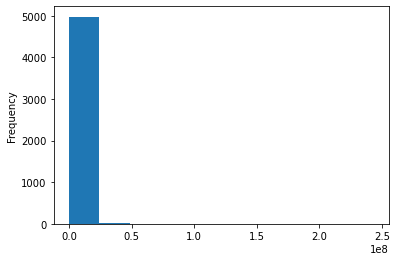

In [11]:
# check prediction accuracy with histogram of MSEs
y_pred = model.predict(df2)
preds = pd.DataFrame()
preds['y_pred'] = y_pred
preds['y_true'] = y2
preds['mse'] = (preds['y_pred'] - preds['y_true'])**2
preds['mse'].plot.hist()
# preds[preds['mse']>100]

In [12]:
# Check if correct single features are weighted as significant, 'match' will be true if correct
coef = pd.DataFrame(df2.columns, columns=['features'])
coef['coef_'] = abs(model.coef_) > 0.5
regs = coef.head(n_features).copy()
regs['true'] = abs(w_features) > 0.5
regs['match'] = regs['coef_'] == regs['true'] 
regs['match'].value_counts()
regs

,features,coef_,true,match
0,0,True,True,True
1,1,False,False,True
2,2,True,True,True
3,3,False,False,True
4,4,False,False,True
5,5,True,True,True
6,6,False,False,True
7,7,False,False,True
8,8,True,True,True
9,9,False,False,True


In [15]:
# Check if correct interaction terms are weighted as significant, element wise against the ordered_true_interaction_terms 
coef = pd.DataFrame(df2.columns, columns=['features'])
coef['coef_'] = abs(model.coef_) > 0.5
its = coef.tail(coef.shape[0]-n_features)
np.array(list(its[its['coef_']==True]['features'])) == out_terms

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ Tr